# Unsupervised Machine Learning Final: Clustering Heart Disease Patient Data
#### Kate Pendavinji

**Repository Link** [Project Repo](https://github.com/kape6379/ML5632_Final.git)

This project will focus on data pertaining to heart disease in patients. This data is from the "V.A. Medical Center in Long Beach, CA" that I sourced through [kaggle](https://www.kaggle.com/datasets/kingabzpro/heart-disease-patients). The goal is to use unsupervised machine learning methods (clustering: hierarchical, kmeans, etc.) in order to see if we can see similarities among symptoms experienced by patients. 

There is a need for utilizing these kinds of methods in the medical world to potentially automate or assist doctors in effectively making diagnoses to patients. "Doctors and clinical experts can diagnose potential much earlier since ML algorithms provide real-time data and analysis. ML in healthcare allows professionals to automate many administrative duties to provide better patient care" [Need for ML in Healthcare](https://www.sciencedirect.com/science/article/pii/S2666603022000069).  If we can identify clear clusters in this data then we will have shown that we can group symptoms and move closer toward efficient diagnoses. 

## Exploratory Data Analysis (EDA) - Inspect, Visualize, and Clean the Data

 Go through the initial data cleaning and EDA and judge whether you need to collect more or different data. 


In [23]:
import scipy as sp
import scipy.stats as stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools


from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage

* Describe the factors or components that make up the dataset.

As we can see are many factors in this dataset comprised of mostly numerical data relating to patients from the V.A. Medical Center in Long Beach, CA. These factors are id numbers, age, sex, chest pain type, resting blood pressure (mmHg), serum cholesterol (mg/dl), if fasting blood sugar > 120, resting ecg resutls, max heart rate achieved, exercised angioma, oldpeak, and slope respectively. 

In [24]:
df = pd.read_csv('heart_disease_patients.csv')

In [25]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        303 non-null    int64  
 1   age       303 non-null    int64  
 2   sex       303 non-null    int64  
 3   cp        303 non-null    int64  
 4   trestbps  303 non-null    int64  
 5   chol      303 non-null    int64  
 6   fbs       303 non-null    int64  
 7   restecg   303 non-null    int64  
 8   thalach   303 non-null    int64  
 9   exang     303 non-null    int64  
 10  oldpeak   303 non-null    float64
 11  slope     303 non-null    int64  
dtypes: float64(1), int64(11)
memory usage: 28.5 KB
None


,id,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope
0,1,63,1,1,145,233,1,2,150,0,2.3,3
1,2,67,1,4,160,286,0,2,108,1,1.5,2
2,3,67,1,4,120,229,0,2,129,1,2.6,2
3,4,37,1,3,130,250,0,0,187,0,3.5,3
4,5,41,0,2,130,204,0,2,172,0,1.4,1


Here we move on to a visualization of frequencies and relationships of these features in our data by way of histogram, bar chart, and scatterplot. 

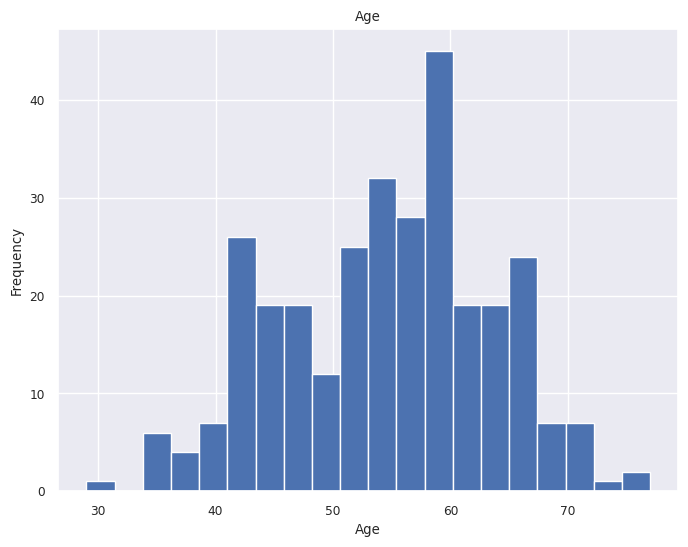

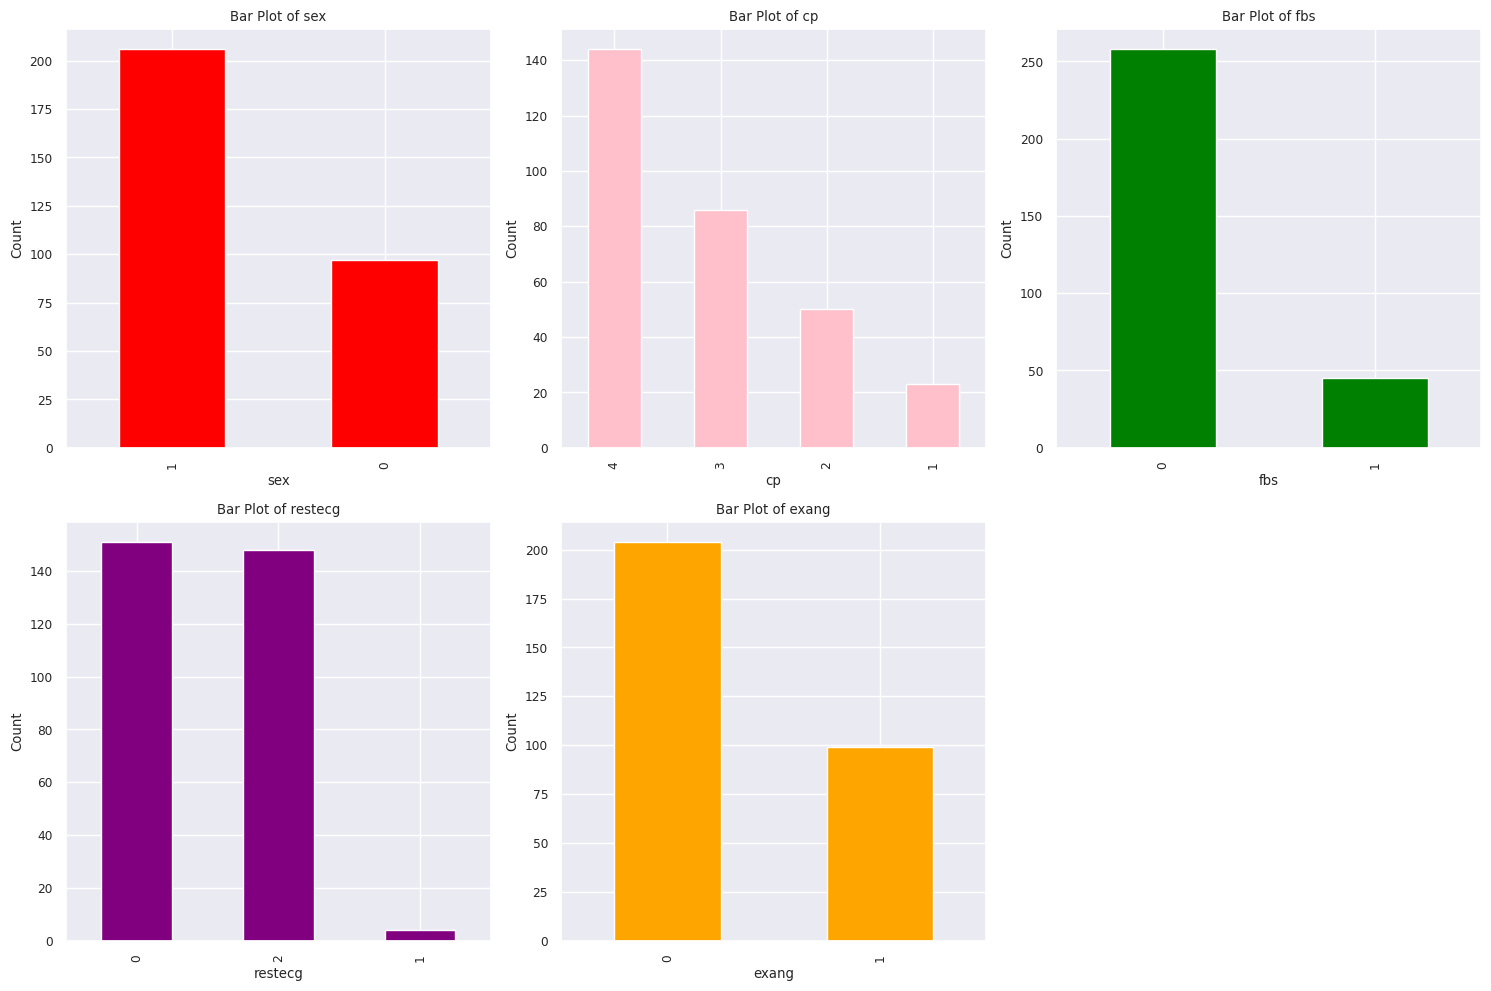

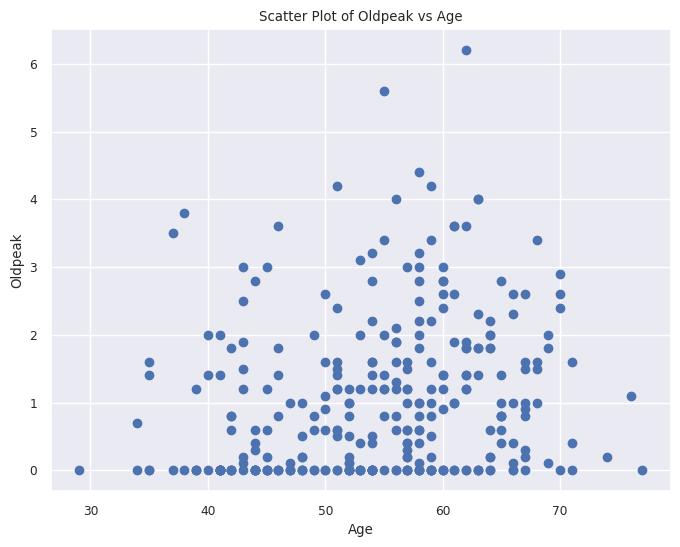

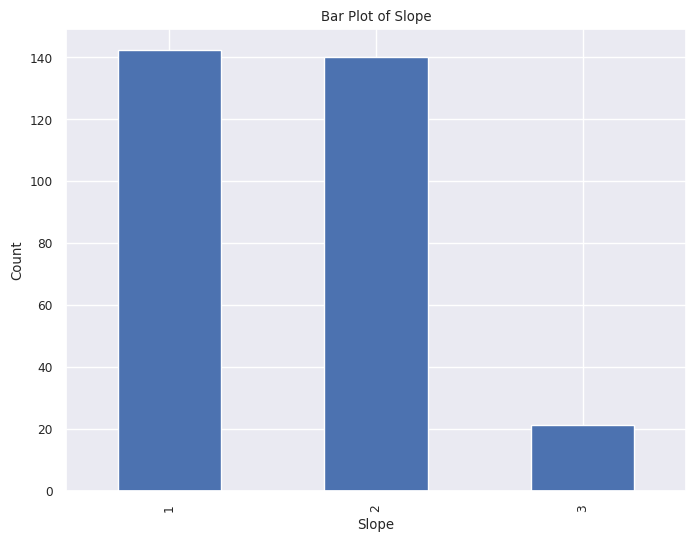

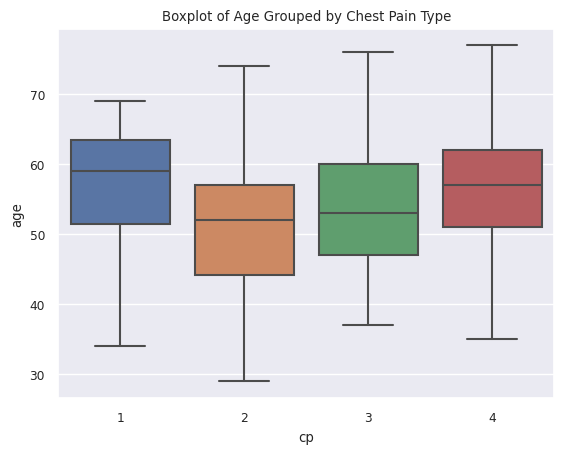

In [26]:
# what are our age ranges looking like?
plt.figure(figsize=(8, 6))
df['age'].hist(bins=20)
plt.title('Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# show categorical data counts
categorical_columns = ['sex', 'cp', 'fbs', 'restecg', 'exang']
colors = ['red','pink','green','purple','orange']
plt.figure(figsize=(15, 10))
for i, column in enumerate(categorical_columns):
    plt.subplot(2, 3, i+1)
    df[column].value_counts().plot(kind='bar', color=colors[i])
    plt.title(f'Bar Plot of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

# checking maybe for relationships?
plt.figure(figsize=(8, 6))
plt.scatter(df['age'], df['oldpeak'])
plt.title('Scatter Plot of Oldpeak vs Age')
plt.xlabel('Age')
plt.ylabel('Oldpeak')
plt.show()

# what is slope
plt.figure(figsize=(8, 6))
df['slope'].value_counts().plot(kind='bar')
plt.title('Bar Plot of Slope')
plt.xlabel('Slope')
plt.ylabel('Count')
plt.show()

# how does age affect chest pain?
sns.boxplot(x='cp', y='age', data=df)
plt.title('Boxplot of Age Grouped by Chest Pain Type')
plt.show()

These charts show us that our data is decently distributed as there aren't too many extreme values, but it's hard to tell how highly or lowly correlated our features are towards each other. We expect all of these features to give us more information on heart disease and its symptoms, so let's explore more on correlation and relationship. 

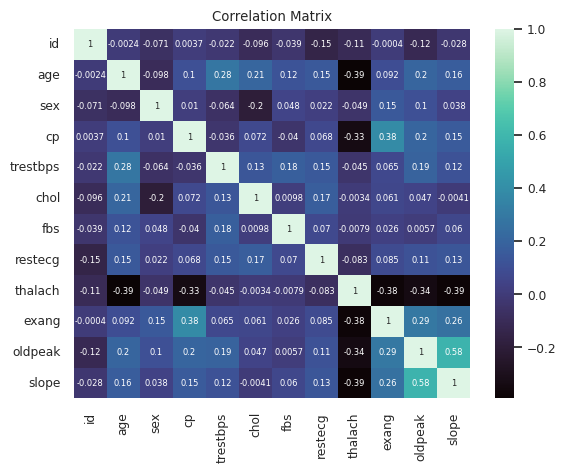

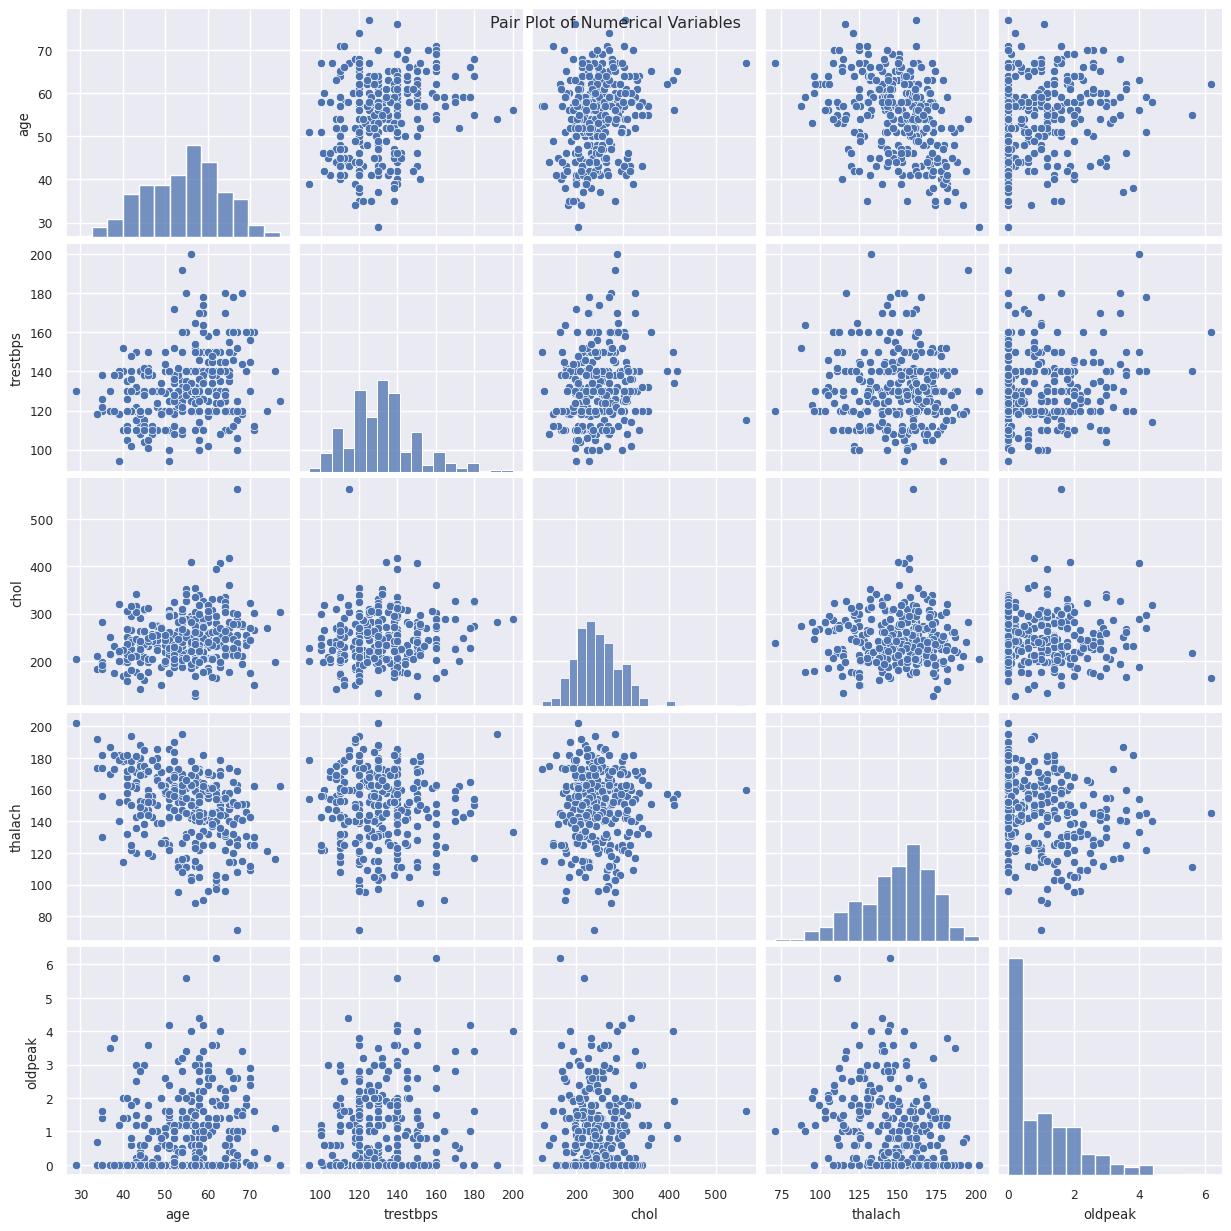

In [27]:
corr = df.corr()
sns.set(font_scale=0.8)
sns.heatmap(corr, annot=True, cmap='mako', annot_kws={"size":6})
plt.title('Correlation Matrix')
plt.show()

pairplot = sns.pairplot(df[['age', 'trestbps', 'chol', 'thalach', 'oldpeak']])
plt.suptitle('Pair Plot of Numerical Variables')
plt.show()

* Describe correlations between different factors of the dataset and justify your assumption that they are correlated or not correlated. You may use numeric or qualitative/graphical analysis for this step.

As we can see from our correlation matrix and pairplot there isn't much evidence of incredibly strong linear relationships. Our correlation matrix shows a stronger relationship between oldpeak and slope, some moderate relationships between chest pain and exercised angioma, and a few moderate negative correlations between thalach and exercised angioma, oldpeak, slope, and chest pain. Our pairplots also suggest against our data having linear correlations as they just represent blobs. 

That being said, with the purpose of this project that is not too big of a deal. We will be performing clustering on our data, so we don't necessarily need our data to be linearly related, we just need to find similarities in symptoms accross patients. 

* You should determine if your data has outliers or needs to be cleaned in any way.

We still need to clean our data and set it up so it's ready to perform analysis using unsupervised learning. First, we check if there exists any null values in our data which we can see there does not. Despite this, we still need to drop the id column as it is irrelevant to our goal.

I then scale all of the continous data (which I have distinguished as different from our categorical data). I then encode our categorical data in order to make handling in our model easier. 

In [28]:
print(df.isnull().sum())
df = df.drop(columns='id')

continuous = ['age', 'trestbps', 'chol', 'thalach']
categorical = ['sex', 'cp', 'fbs', 'restecg', 'exang']

scaler = StandardScaler()
df[continuous] = scaler.fit_transform(df[continuous])

df = pd.get_dummies(df, columns=categorical)

id          0
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
dtype: int64


## Perform Analysis Using Unsupervised Learning Models of your Choice

As a part of my exploratory analysis I will be applying hierarchical clustering on our processed data. The idea is that if we can identify clear clusters then it will show that symptoms clients face can be categorized and thus used to medically inform treatment options.

I am using hierarchical clustering due to the fact that there is a lot of room for me to choose and play around with different distance measures or linkage criteria. If I can show that subgroups can be identified in this data, then I will have considered it successful! In order to visualize if I've correclty identified subgroups, I will use PCA to reduce the dimensionality and thus plot our clusters. 

## Hierarchical Clustering:

Cluster labels: [0 4 1 1 2 2 1 0 0 1 3 0 3 2 0 0 2 2 0 2 3 0 0 1 1 2 0 4 2 1 0 3 0 3 2 2 1
 4 3 3 4 2 0 0 0 1 3 4 0 1 2 3 2 2 3 1 2 2 0 3 3 1 1 0 3 1 1 0 1 1 0 3 4 0
 2 0 1 0 2 4 1 0 2 0 2 2 2 3 0 0 0 1 1 2 0 3 3 1 2 2 2 2 0 0 1 2 3 0 1 3 3
 3 2 3 4 3 0 2 3 4 3 0 3 1 0 0 1 1 2 3 0 3 2 2 2 0 4 4 3 1 3 0 2 1 3 2 4 2
 2 0 0 3 0 3 4 4 3 2 0 1 2 0 2 3 2 3 2 0 3 3 4 3 0 0 4 4 2 1 2 0 2 0 2 1 0
 0 2 4 0 0 2 1 3 4 4 3 0 0 0 0 0 0 0 0 2 3 1 3 2 3 2 1 1 0 2 1 2 0 4 2 0 0
 2 4 3 2 2 0 3 3 0 1 3 0 0 1 4 2 0 2 2 0 0 1 3 4 2 3 2 0 3 4 4 0 2 2 3 4 0
 2 2 0 0 2 1 3 3 1 2 2 1 4 3 3 3 0 0 2 0 3 1 2 1 2 3 1 1 2 0 2 0 0 1 1 3 2
 4 3 3 4 3 0 2]

[0, 1, 2, 3, 4]
[84 49 77 63 30]


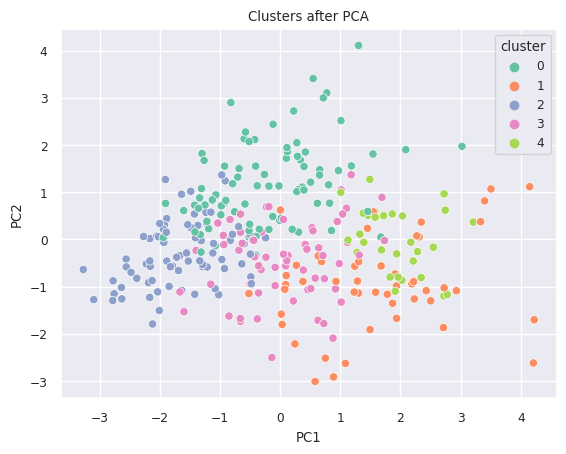

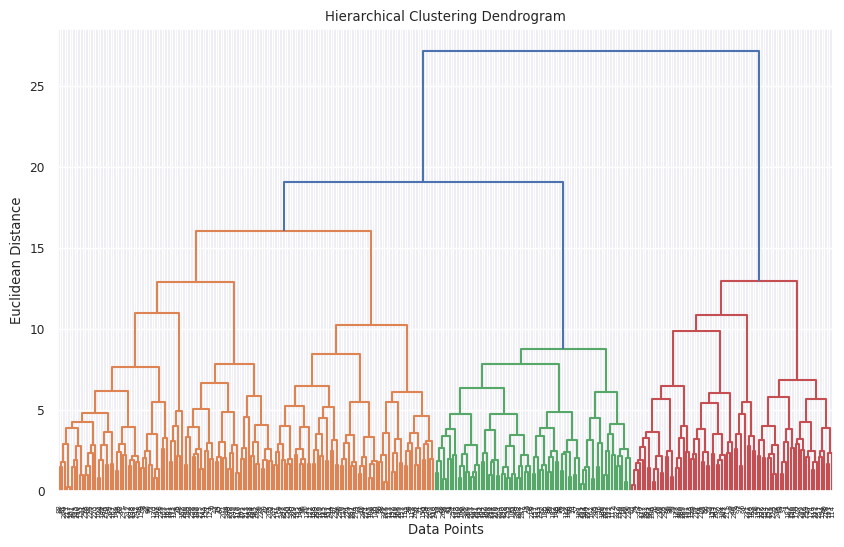

In [29]:
data = df
# preliminary hierarchical model
model = AgglomerativeClustering(n_clusters=5, linkage='ward')
model.fit(data)

# look at what our clusters look like
print("Cluster labels:", model.labels_)

# show how many labels are distributed within our clusters
counts = np.bincount(model.labels_)
print('\n[0, 1, 2, 3, 4]')
print(counts)


# visualize using principal component analysis
pca = PCA(n_components=2)
pca_data = pca.fit_transform(data)


pca_df = pd.DataFrame(data=pca_data, columns=['PC1', 'PC2'])
pca_df['cluster'] = model.labels_

sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster', palette='Set2')
plt.title('Clusters after PCA')
plt.show()

# view dendrogram

link = linkage(data, method='ward')

plt.figure(figsize=(10, 6))
dendrogram(link, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Euclidean Distance')
plt.show()

## Hyperparameter Optimization: 

Below you will see my hyperparameter optimization. The linkage and affinities are as follows from left to right:

* Ward + Euclidean
* Complete + Euclidean
* Complete + l1
* Complete + l2
* Complete + Manhattan
* Complete + Cosine
* Average + Euclidean
* Average + l1
* Average + l2
* Average + Manhattan
* Average + Cosine
* Single + Euclidean
* Single + l1
* Single + l2
* Single + Manhattan
* Single + Cosine.

Since this data, unlike in HW 2, does not provide any ground truths we cannot use label permutation comparisons to filter through which distance and linkage criteria optimizes our results. Instead, we can visually see these results through PCA. You'll notice that it's obvious that our initial default setting of Ward + Euclidian was the best combination of parameters (it offers the most distinct, well-distributed clusters), so this is what we will go with. 

<table>
  <tr>
    <td><img src="ward_euclidean.png" alt="Ward Euclidean" style="width: 500px;"/></td>
    <td><img src="complete_euclidean.png" alt="Complete Euclidean" style="width: 500px;"/></td>
  </tr>
  <tr>
    <td><img src="complete_l1.png" alt="Complete l1" style="width: 500px;"/></td>
    <td><img src="complete_l2.png" alt="Complete l2" style="width: 500px;"/></td>
  </tr>
  <tr>
    <td><img src="complete_manhattan.png" alt="Complete Manhattan" style="width: 500px;"/></td>
    <td><img src="complete_cosine.png" alt="Complete Cosine" style="width: 500px;"/></td>
  </tr>
  <tr>
    <td><img src="average_euclidean.png" alt="Average Euclidean" style="width: 500px;"/></td>
    <td><img src="average_l1.png" alt="Average l1" style="width: 500px;"/></td>
  </tr>
  <tr>
    <td><img src="average_l2.png" alt="Average l2" style="width: 500px;"/></td>
    <td><img src="average_manhattan.png" alt="Average Manhattan" style="width: 500px;"/></td>
  </tr>
  <tr>
    <td><img src="average_cosine.png" alt="Average Cosine" style="width: 500px;"/></td>
    <td><img src="single_euclidean.png" alt="Single Euclidean" style="width: 500px;"/></td>
  </tr>
  <tr>
    <td><img src="single_l1.png" alt="Single l1" style="width: 500px;"/></td>
    <td><img src="single_l2.png" alt="Single l2" style="width: 500px;"/></td>
  </tr>
  <tr>
    <td><img src="single_manhattan.png" alt="Single Manhattan" style="width: 500px;"/></td>
    <td><img src="single_cosine.png" alt="Single Cosine" style="width: 500px;"/></td>
    </tr>
</table>


Cluster labels: [0 1 1 1 2 2 1 0 0 1 0 0 0 2 0 0 2 2 0 2 0 0 0 1 1 2 0 1 2 1 0 0 0 0 2 2 1
 1 0 0 1 2 0 0 0 1 0 1 0 1 2 0 2 2 0 1 2 2 0 0 0 1 1 0 0 1 1 0 1 1 0 0 1 0
 2 0 1 0 2 1 1 0 2 0 2 2 2 0 0 0 0 1 1 2 0 0 0 1 2 2 2 2 0 0 1 2 0 0 1 0 0
 0 2 0 1 0 0 2 0 1 0 0 0 1 0 0 1 1 2 0 0 0 2 2 2 0 1 1 0 1 0 0 2 1 0 2 1 2
 2 0 0 0 0 0 1 1 0 2 0 1 2 0 2 0 2 0 2 0 0 0 1 0 0 0 1 1 2 1 2 0 2 0 2 1 0
 0 2 1 0 0 2 1 0 1 1 0 0 0 0 0 0 0 0 0 2 0 1 0 2 0 2 1 1 0 2 1 2 0 1 2 0 0
 2 1 0 2 2 0 0 0 0 1 0 0 0 1 1 2 0 2 2 0 0 1 0 1 2 0 2 0 0 1 1 0 2 2 0 1 0
 2 2 0 0 2 1 0 0 1 2 2 1 1 0 0 0 0 0 2 0 0 1 2 1 2 0 1 1 2 0 2 0 0 1 1 0 2
 1 0 0 1 0 0 2]

[0, 1, 2, 3]
[147  79  77]


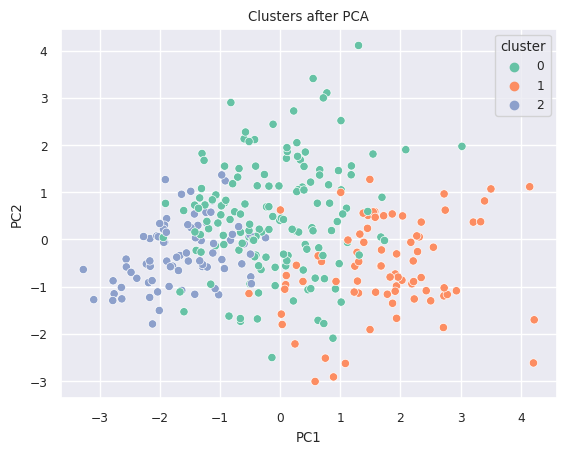

In [32]:
data = df
# model after hyperparameter optimization and modification of clusters used
model = AgglomerativeClustering(n_clusters=3, linkage='ward', metric = 'euclidean')
model.fit(data)

# visualize clusters and where they're newly distributed
print("Cluster labels:", model.labels_)

counts = np.bincount(model.labels_)
print('\n[0, 1, 2, 3]')
print(counts)

#visual representation of clusters using principal component analysis
pca = PCA(n_components=2)
pca_data = pca.fit_transform(data)


pca_df = pd.DataFrame(data=pca_data, columns=['PC1', 'PC2'])
pca_df['cluster'] = model.labels_

sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster', palette='Set2')
plt.title('Clusters after PCA')
plt.show()

## Kmeans Clustering:

Next we will compare our hierarchical model to our kmeans model in order to determine if there is a clustering method better suited for this issue. 

Cluster labels: [3 2 2 3 4 1 3 0 1 3 1 0 1 4 1 1 4 1 4 4 2 0 1 3 2 1 0 3 4 2 1 1 0 1 4 4 2
 2 2 1 2 4 0 1 0 1 1 3 0 1 4 1 4 4 2 2 1 4 1 2 0 1 2 0 2 3 3 1 3 3 0 1 2 1
 4 0 3 0 4 2 3 0 4 0 4 4 4 1 0 1 0 3 1 4 0 4 2 3 1 4 4 4 0 0 1 4 1 1 3 4 0
 2 4 3 2 4 1 4 2 3 4 3 1 3 0 4 3 2 4 1 1 4 4 4 4 1 3 2 4 1 1 0 4 2 1 4 0 4
 4 0 0 4 0 0 2 2 0 0 0 1 4 0 1 2 4 1 1 0 4 4 3 2 0 0 2 2 4 2 4 1 4 0 4 3 0
 1 4 2 0 1 4 3 4 2 2 2 0 4 4 0 4 0 1 0 4 0 3 2 1 0 4 3 4 0 4 1 4 4 2 0 4 4
 4 2 1 4 4 0 2 2 1 3 1 2 1 3 2 4 4 4 4 4 4 3 2 2 1 2 1 1 2 2 2 0 4 4 1 2 0
 1 4 0 0 4 3 2 1 1 4 4 2 3 2 2 1 0 0 4 1 1 3 4 2 4 1 3 3 1 1 1 1 0 3 3 2 4
 2 2 4 3 2 1 4]

[0, 1, 2, 3, 4]
[54 69 57 38 85]


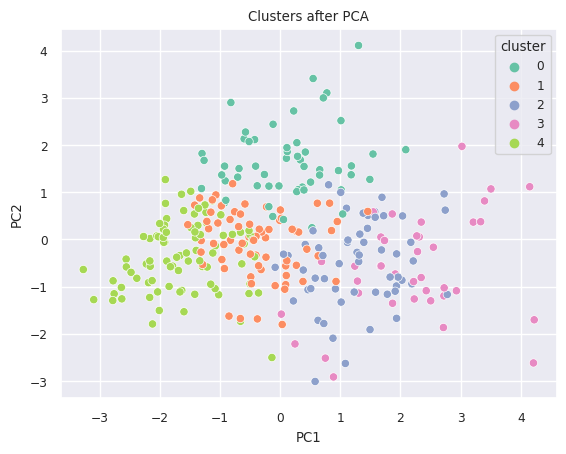

In [31]:
# initialize kmeans model + fit
kmeans = KMeans(n_clusters=5, n_init=10, random_state=42)
kmeans.fit(data)

kLabel = kmeans.labels_

# visualize clusters
print("Cluster labels:", kLabel)

kcounts = np.bincount(kLabel)
print('\n[0, 1, 2, 3, 4]')
print(kcounts)

# visual representation of clussters using principal component analysis
kpca = PCA(n_components=2)
kpca_data = kpca.fit_transform(data)


kpca_df = pd.DataFrame(data=kpca_data, columns=['PC1', 'PC2'])
kpca_df['cluster'] = kmeans.labels_

sns.scatterplot(data=kpca_df, x='PC1', y='PC2', hue='cluster', palette='Set2')
plt.title('Clusters after PCA')
plt.show()

## Discussion and Conclusions

Based off of our PCA visualizations alone it seems as though kmeans just may do a better job at clustering our data. The data is better distributed among all of the clusters and visually the borders between the colors are more distinct.

With that being said, I was required to pre-identify number of clusters with kmeans. I chose to do so with hierarchical clustering for cohesiveness, but after seeing the results of my dendogram I modified the number of clusters to 3. This gave me 3 incredibly distinct groups among my clusters that is relatively well distributed.

Overall, I believe that the unsupervised learning method of clustering is a fantastic real world approach for hospitals to provide information to medical professionals to make informed decisions. We've seen that our learning models can clearly distinguish similarities between symptoms of patients which can lead to life-saving care. Especially as we've seen unprecedented times and overwhelmed healthcare institutions this would be a crucial implementation to modernize the healthcare system. 